In [9]:
#importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio.plot
import rasterio
from rasterio import plot
import math
from pylandtemp import emissivity

In [15]:
def LST(band4,band5,band10):
    '''Calculates the Land Surface Temperature by computing Brightness Temperature(BT),
       Normalised Differentiated Vegetation Index (NDVI) and emissivity. Inputs are Band 4,
       Band 5 and Band 10 of LANDSAT 8'''
    
    #converting into float
    red = band4.read(1).astype('float64')   #band 4 is red
    nir = band5.read(1).astype('float64')   #band 5 is nir
    Band10 = band10.read(1).astype('float64') # band 10 is thermal band 1

    #calculating NDVI
    ndviImage= np.where((nir+red)==0.0,0,(nir-red)/(nir+red))

    #calculating emissivity
    e1,e2 = emissivity(ndviImage, emissivity_method='avdan', landsat_band_4=red)


    #calculating TOA and BT 
    #(K1_CONSTANT_BAND_10: 774.8853)
    #(K2_CONSTANT_BAND_10: 1321.0789)
    # RADIANCE_MULT_BAND_10: 0.00033420001273043454
    # RADIANCE_ADD_BAND_10: 0.10000000149011612
    
    TOA = (0.00033420001273043454* Band10) + 0.10000000149011612
    A = 774.8853149414062/TOA
    BT = (1321.078857421875/np.log(A+1)) -273.15

    LST=(BT/(1+(0.00115*BT/1.4388)*np.log(e1)))

    return LST

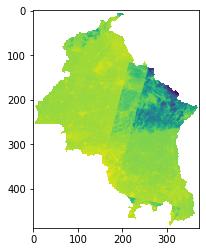

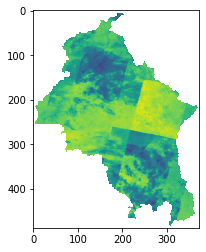

In [17]:
months = ['jan','feb','mar','april','may','june','july','aug','sept','oct','nov','Dec']

for mon in months:
    b4 = rasterio.open('D:/Python project/Test/LANDSAT_8_B4_'+mon+'.tif')
    b5 = rasterio.open('D:/Python project/Test/LANDSAT_8_B5_'+mon+'.tif')
    b10 = rasterio.open('D:/Python project/Test/LANDSAT_8_B10_'+mon+'.tif')

    lst_out = LST(b4,b5,b10)
    plot.show(lst_out)

    out = rasterio.open('D:/Python project/Test/LST'+mon+'.tiff','w',driver='Gtiff',
                        width=b4.width,
                        height = b4.height,
                        count=1, crs=b4.crs,
                        transform=b4.transform,
                        dtype='float64')
    arr = np.array(lst_out)
    savetxt('D:/Python project/Test/LST'+mon+'.csv',arr,delimiter = ',')
    
    out.write(lst_out,1)
    out.close()